In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Defining Transforms

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10, fill=255),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, class_names, class_to_idx, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        self.labels = pd.read_excel(label_file, usecols=[1], names=['eye_color'])['eye_color'].tolist()

        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])

        
        # print(self.labels)
        # print(self.image_files)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\cartoon_set\img'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\cartoon_set\labels.xlsx'
root_dir_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\cartoon_set_test\img'
label_file_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\cartoon_set_test\labels.xlsx'

# Define the class names and their corresponding indexes
class_names = ['brown', 'blue', 'green', 'grey', 'black']
class_to_idx = {'brown': 0, 'blue': 1, 'green': 2, 'grey': 3, 'black': 4}

train_data = MyDataset(root_dir, label_file, class_names, class_to_idx, transform=train_transform)
test_data = MyDataset(root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)

torch.manual_seed(42)

# Create the DataLoader objects for the training and validation sets
train_loader = DataLoader(train_data, batch_size=125, shuffle=True)
test_loader = DataLoader(test_data, batch_size=125, shuffle=True)

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')



['brown', 'blue', 'green', 'grey', 'black']
Training images available: 10000
Testing images available:  2500


Displaying a batch of images

Label: [1 0 1 4 2 3 0 4 4 1]
Class: blue brown blue black green grey brown black black blue


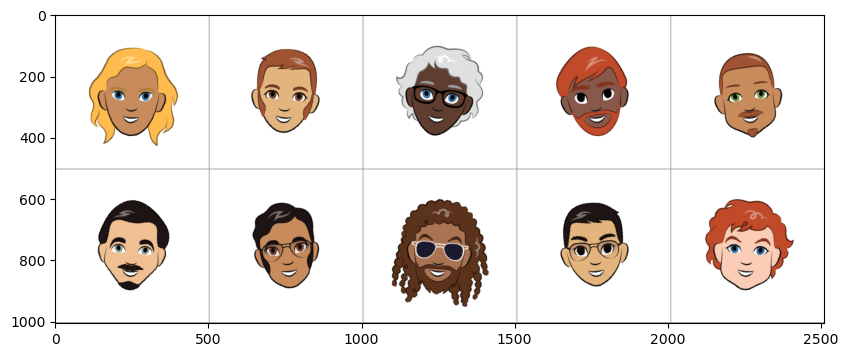

In [4]:
# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 10 labels
print('Label:', labels[:10].numpy())
print('Class:', *np.array([class_names[x] for x in labels[:10].numpy()]))

im = make_grid(images[:10], nrow=5) 

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));


# Defining the model

In [5]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # (((500−2)/2)−2)/2=123.5
        # (((500−2)/2)−2)/2=123.5
        self.fc1 = nn.Linear(123*123*16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 123*123*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [6]:
torch.manual_seed(42)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=242064, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

In [7]:
import time
start_time = time.time()

epochs = 10

# Limit nr of batches for testing
#max_trn_batch = 10
#max_val_batch = 2

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # For the calculations later

        # Limit the number of batches for testing
        #if b == max_trn_batch:
        #    break

        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(40) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{125*b:4}/10000]  loss: {loss.item():10.8f}  |  accuracy: {trn_corr.item()*100/(125*b):7.2f}%   |   Duration: {time.time() - start_time:.0f} seconds')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches for test
            #if b == max_val_batch:
            #    break

            # Apply the model
            y_val_pred = CNNmodel(X_test)
            loss = criterion(y_val_pred, y_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val_pred.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

epoch:  0  batch:   40 [5000/10000]  loss: 1.51896787  |  accuracy:   26.42%   |   Duration: 489 seconds
epoch:  0  batch:   80 [10000/10000]  loss: 0.83319432  |  accuracy:   45.25%   |   Duration: 920 seconds
epoch:  1  batch:   40 [5000/10000]  loss: 0.49684703  |  accuracy:   79.52%   |   Duration: 1456 seconds
epoch:  1  batch:   80 [10000/10000]  loss: 0.41300425  |  accuracy:   81.41%   |   Duration: 1882 seconds
epoch:  2  batch:   40 [5000/10000]  loss: 0.40280432  |  accuracy:   83.32%   |   Duration: 2411 seconds
epoch:  2  batch:   80 [10000/10000]  loss: 0.42022917  |  accuracy:   84.03%   |   Duration: 2821 seconds
epoch:  3  batch:   40 [5000/10000]  loss: 0.39672124  |  accuracy:   85.20%   |   Duration: 3351 seconds
epoch:  3  batch:   80 [10000/10000]  loss: 0.25934485  |  accuracy:   84.71%   |   Duration: 3771 seconds
epoch:  4  batch:   40 [5000/10000]  loss: 0.43119633  |  accuracy:   85.98%   |   Duration: 4300 seconds
epoch:  4  batch:   80 [10000/10000]  loss: 

Inspect results


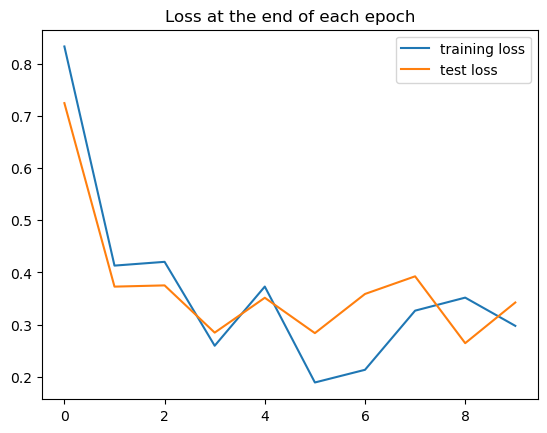

In [8]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()


[1835, 2076, 2077, 2086, 2091, 2083, 2078, 2081, 2087, 2090]
Test accuracy: 83.600%


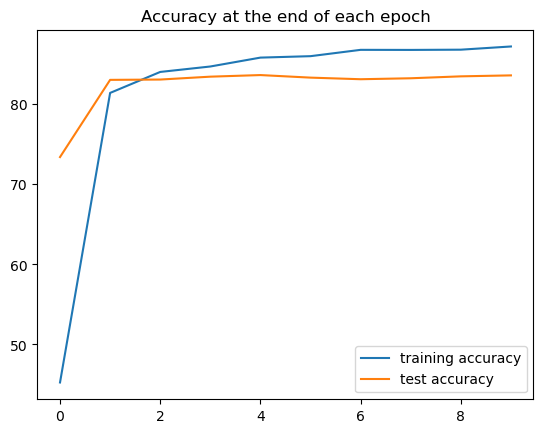

In [10]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]*100/2500:.3f}%')
plt.plot([t/100 for t in train_correct], label='training accuracy')
plt.plot([t/25 for t in test_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();
